<a href="https://colab.research.google.com/github/Uday-ashes-uday/deep-learning/blob/main/vision_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision

In [ ]:
try:
  from torchinfo import summary
  print('summary imported')

except:
  !pip install torchinfo
  from torchinfo import summary
  print('installed and imported')

installed and imported


In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

imported helper functions by just copying them in above cells

In [ ]:
im_path=download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",destination='pizza_steak_sushi')

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


In [ ]:
#set training path and test path

train_dir='/content/data/pizza_steak_sushi/train'
test_dir='/content/data/pizza_steak_sushi/test'

In [ ]:
#create transforms to trun images into desired img size and into tensors

IMG_SIZE=224

from torchvision import transforms

manual_transforms=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                     transforms.ToTensor()])


print(f'manually created transforms are {manual_transforms}')

manually created transforms are Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [ ]:
BATCH_SIZE=32

#create dataloaders

train_dataloader,test_dataloader,class_names=create_dataloaders(train_dir=train_dir,test_dir=test_dir,transform=manual_transforms,batch_size=BATCH_SIZE)

In [ ]:
train_dataloader

In [ ]:
test_dataloader

In [ ]:
class_names

['pizza', 'steak', 'sushi']

In [ ]:
len(train_dataloader),len(test_dataloader)

(8, 3)

In [ ]:
#visualizing a single image

#get first batch by converting train dataloader into iterator and by getting the first batch

imag_batch,lab_batch=next(iter(train_dataloader))

In [ ]:
len(imag_batch),len(lab_batch)

(32, 32)

Text(0.5, 1.0, 'pizza')

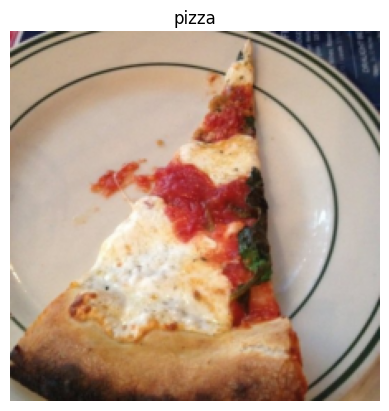

In [ ]:
import random
n=random.randint(0,len(imag_batch)-1)
plt.imshow(imag_batch[n].permute(1,2,0))
plt.axis('off')
plt.title(class_names[lab_batch[n]])

In [ ]:
#calculate number of patches

height=224
width=224
color_channels=3
patch_size=16

#calculate number of patches

number_of_patches=int(height*width/patch_size**2)
number_of_patches

196

In [ ]:
#input shape

embedding_layer_input_shape=(height,width,color_channels)


#output shape

embedding_layer_output_shape=(number_of_patches,patch_size**2*color_channels)



print(f'input shape {embedding_layer_input_shape}')

print(f'output shape {embedding_layer_output_shape}')

input shape (224, 224, 3)
output shape (196, 768)


Text(0.5, 1.0, 'sushi')

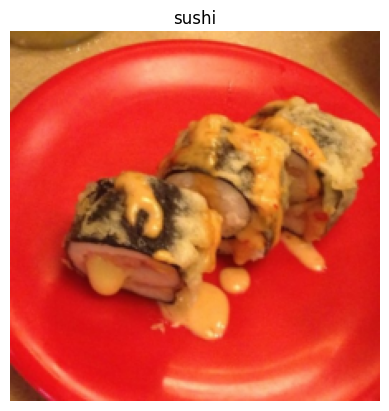

In [ ]:
#visualize an image and patchify it

import random
n=random.randint(0,len(imag_batch)-1)
plt.imshow(imag_batch[n].permute(1,2,0))
plt.axis('off')
plt.title(class_names[lab_batch[n]])

In [ ]:
image=imag_batch[10]
image.shape


torch.Size([3, 224, 224])

In [ ]:
image=image.permute(1,2,0)
image.shape

torch.Size([224, 224, 3])

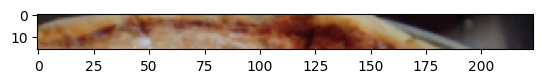

In [ ]:
#showing top row as a patch
plt.imshow(image[:16,:,:]);

In [ ]:
image.shape

torch.Size([224, 224, 3])

In [ ]:
#splitting top row into 16 patches

img_size=224
patch_size=16
num_patches=img_size/patch_size

#check whether image size is divissible by patch size

assert img_size%patch_size==0,'image size not divisible by patch size'




In [ ]:
img_size%patch_size

0

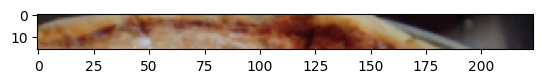

In [ ]:
plt.imshow(image[:patch_size,:,:]);

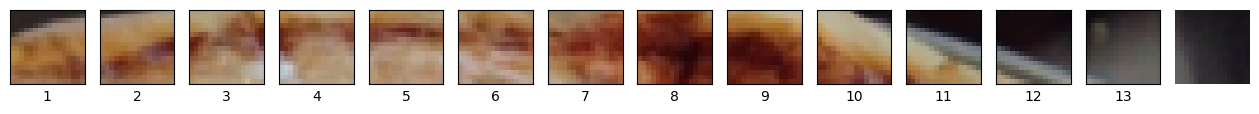

In [ ]:
img_size=224
patch_size=16
number_of_patches=img_size//patch_size

#check whether img_size is divisible by patch_size

assert img_size//patch_size,'image size not divisble by patch size'

#create empty subplots

fig,ax=plt.subplots(nrows=1,ncols=number_of_patches,sharex=True,sharey=True,figsize=(patch_size,patch_size))
plt.axis('off')

for i,patch in enumerate(range(0,img_size,patch_size)):
  ax[i].imshow(image[:patch_size,patch:patch+patch_size,:])
  ax[i].set_xlabel(i+1)
  ax[i].set_xticks([])
  ax[i].set_yticks([])



Text(0.5, 0.98, 'pizza')

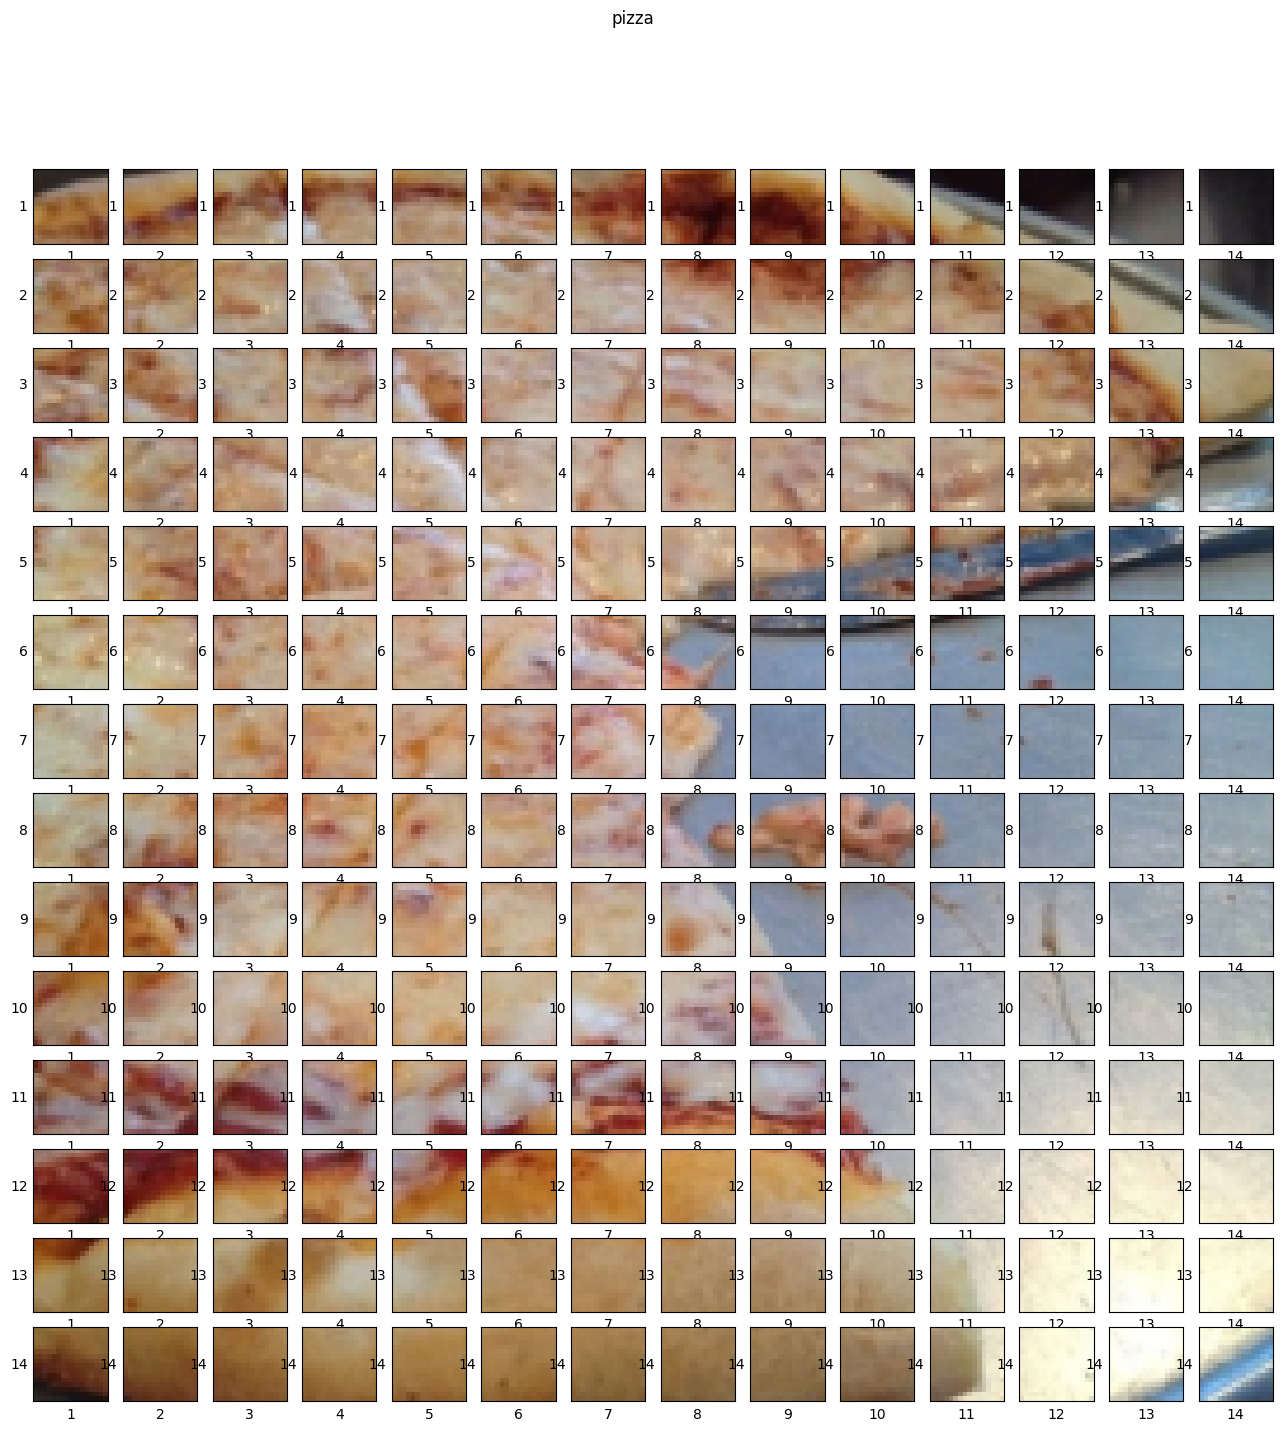

In [ ]:
#convert whole image into patches

img_size=224
patch_size=16

#check whether image size is divisible by patch size
assert img_size%patch_size==0,'image size is not divisble by patch size'

fig,ax=plt.subplots(nrows=img_size//patch_size,
                    ncols=img_size//patch_size,
                    sharex=True,
                    sharey=True,
                    figsize=(patch_size,patch_size))

for i,patch_height in enumerate(range(0,img_size,patch_size)):
  for j,patch_width in enumerate(range(0,img_size,patch_size)):
    ax[i,j].imshow(image[patch_height:patch_height+patch_size,patch_width:patch_width+patch_size,:])
    ax[i,j].set_ylabel(i+1,rotation='horizontal',horizontalalignment='right',verticalalignment='center')
    ax[i,j].set_xlabel(j+1)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])

fig.suptitle(f'{class_names[lab_batch[10]]}')


In [ ]:
class_names[lab_batch[10]]

'pizza'

In [ ]:
from torch import nn

patch_size=16

conv2d=nn.Conv2d(in_channels=3,
                 out_channels=768,
                 kernel_size=patch_size,
                 stride=patch_size,
                 padding=0)

In [ ]:
image.shape

torch.Size([224, 224, 3])

In [ ]:
image.shape

torch.Size([224, 224, 3])

In [ ]:
image=image.unsqueeze(0)

In [ ]:
im=conv2d(image.permute(0,3,1,2))

In [ ]:
im.shape

torch.Size([1, 768, 14, 14])

In [ ]:
im.requires_grad

True

In [ ]:
import random

#get 5 random numbers between 0,750

random_indx=random.sample(range(0,750),k=5)
random_indx

[431, 643, 478, 210, 623]

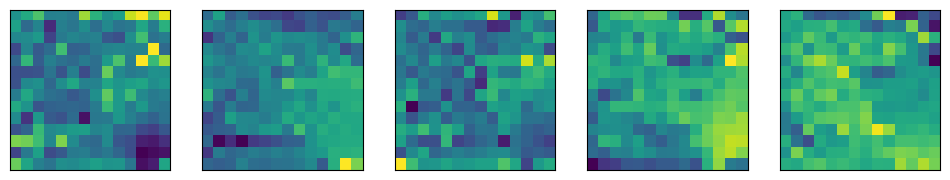

In [ ]:
#create subplots of 5

fig,axs=plt.subplots(nrows=1,ncols=5,figsize=(12,12))

for i,idx in enumerate(random_indx):
  im_feat=im[:,idx,:,:]
  axs[i].imshow(im_feat.squeeze().detach().numpy())
  axs[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])

In [ ]:
from torch import nn

#create flatten layer

flatten=nn.Flatten(start_dim=2,end_dim=3)

In [ ]:
im_f=flatten(im)

In [ ]:
im_f.shape

torch.Size([1, 768, 196])

In [ ]:
im.shape

torch.Size([1, 768, 14, 14])

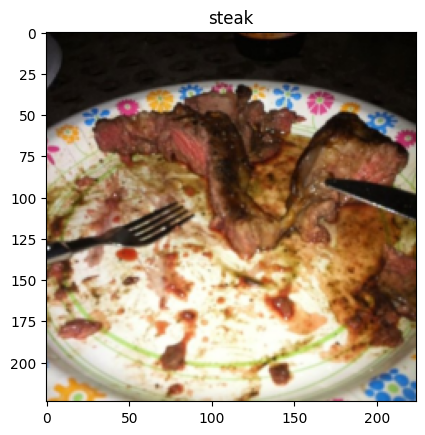

In [ ]:
#put everystep in a n order
import random

b=random.randint(0,len(imag_batch)-1)

image_r=imag_batch[b]
l_r=class_names[lab_batch[b].item()]

plt.imshow(image_r.permute(1,2,0));
plt.title(l_r)

image_c=conv2d(image_r.unsqueeze(0))
image_c.shape
image_f=flatten(image_c)
image_f.shape
image_f_p=image_f.permute(0,2,1)

In [ ]:
image_f_p.shape

torch.Size([1, 196, 768])

In [ ]:
image_f_p=image_f_p[:,:,0]


In [ ]:
image_f_p.shape

torch.Size([1, 196])

In [ ]:
plt.figure(figsize=(22,22))
plt.imshow(image_f_p.detach().numpy());
plt.axis(False);

In [ ]:
class PatchEmbedding(nn.Module):

  def __init__(self,in_channels:int=3,patch_size:int=16,embedded_dim:int=768):
    super().__init__()

    #create a layer to turn image into an embedding layer

    self.patcher=nn.Conv2d(in_channels=in_channels,out_channels=embedded_dim,kernel_size=patch_size,stride=patch_size,padding=0)

    self.flatten=nn.Flatten(start_dim=2,end_dim=3)


  def forward(self,x):
    #check whether input resolution is divisible by patch size
    assert x.shape[-1]%patch_size==0 ,f'input resolution {x.shape[-1]}is not divisible by patch size{patch_size}'

    #perform the forward pass

    x_patched=self.patcher(x)
    x_flatten=self.flatten(x_patched)

    return x_flatten.permute(0,2,1)

In [ ]:
patchfy=PatchEmbedding(in_channels=3,patch_size=16,embedded_dim=768)

In [ ]:
patched_em_image=patchfy(image_r.unsqueeze(0))
patched_em_image.shape

torch.Size([1, 196, 768])

In [ ]:
rand_image_tensor=torch.randn(1,3,224,224)
rand_image_tensor_un=torch.randn(1,3,225,225)

In [ ]:
patchfy(rand_image_tensor)

tensor([[[ 0.8819,  0.0850, -0.0385,  ...,  0.2318, -0.3975,  0.8114],
         [ 0.3573,  0.5368,  0.9877,  ...,  0.0579,  0.8254,  0.8216],
         [ 0.8278,  1.1671,  0.3013,  ..., -0.2410,  0.9174, -0.7823],
         ...,
         [ 0.3433, -0.1679,  0.2687,  ..., -0.0042,  0.5736,  0.1165],
         [-0.7766, -0.2151,  0.2674,  ...,  0.2615, -0.9020,  0.4523],
         [-0.0191,  0.7884, -0.7590,  ..., -0.3135,  0.1664, -0.4791]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
#make a learnable parameter

batch_dimension=patched_em_image.shape[0]
embedding_dimension=patched_em_image.shape[-1]

class_token=nn.Parameter(torch.randn(batch_dimension,1,embedding_dimension),requires_grad=True)



In [ ]:
#concatenate a class token before patches
patch_emb_token=torch.cat((class_token,patched_em_image),dim=1)

In [ ]:
patch_emb_token.shape

torch.Size([1, 197, 768])

In [ ]:
#calculate number of patches

number_of_patches=int(height*width)//patch_size**2


#get the embedding dimension

embedding_dim=patch_emb_token.shape[-1]

#create a learnable 1D positional embedding

position_embedding=nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dim),requires_grad=True)

position_embedding,position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
patch_and_position_embedding=patch_emb_token+position_embedding

In [ ]:
patch_and_position_embedding

tensor([[[ 2.2718,  1.1587, -0.1792,  ...,  0.5091,  2.7757, -0.7023],
         [ 1.0382,  0.9716,  1.0816,  ...,  1.0263,  0.9831,  1.0197],
         [ 1.0118,  1.0162,  1.0702,  ...,  1.0175,  0.9677,  0.9711],
         ...,
         [ 1.5449,  0.9520,  1.8183,  ...,  1.4679,  0.7952,  0.7814],
         [ 1.2992,  0.7793,  1.7484,  ...,  1.6655,  0.7448,  1.2693],
         [ 1.3673,  0.8701,  1.6302,  ...,  1.5789,  0.5882,  1.0560]]],
       grad_fn=<AddBackward0>)

In [ ]:
new_im=imag_batch[12]

#set patch_size

patch_size=16

#get shapes of original image

height,width=new_im.shape[1],new_im.shape[2]

#get image tensor and add batch dimension

new_im=new_im.unsqueeze(0)

#create a patch embedding layer

patch_emb=PatchEmbedding(in_channels=3,patch_size=patch_size,embedded_dim=768)

patch_layer=patch_emb(new_im)

patch_layer.shape

#create a class token

batch_si=patch_layer.shape[0]
embedding_dim=patch_layer.shape[-1]

class_token=nn.Parameter(torch.ones(batch_si,1,embedding_dim),requires_grad=True)

class_token=torch.cat((class_token,patch_layer),dim=1)

class_token.shape

#create positional embedding

number_of_patches=int(height*width)//(patch_size**2)

positional_embedding=nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dim),requires_grad=True)

patch_and_positional=class_token+positional_embedding

patch_and_positional

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.3332, 0.7671, 0.9644,  ..., 1.0059, 1.2232, 0.7226],
         [1.3857, 0.7668, 0.9619,  ..., 0.9929, 1.2338, 0.7744],
         ...,
         [1.5911, 0.6800, 0.8688,  ..., 1.0388, 1.3499, 0.6321],
         [1.5440, 0.8020, 0.7913,  ..., 0.8833, 1.3377, 0.6941],
         [1.5379, 0.8379, 0.8110,  ..., 0.9980, 1.1846, 0.7773]]],
       grad_fn=<AddBackward0>)

In [ ]:
class MultiHeadAttn(nn.Module):

  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:int=0):
    super().__init__()
    #create a norm layer

    self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)

    #create a multihead attention

    self.multihead=nn.MultiheadAttention(embed_dim=embedding_dim,
                                         num_heads=num_heads,
                                         dropout=attn_dropout,
                                         batch_first=True)

  def forward(self,x):
    x=self.layer_norm(x)
    attn_output,_=self.multihead(query=x,key=x,value=x,need_weights=False)
    return attn_output

In [ ]:
multihead_atten_block=MultiHeadAttn(embedding_dim=768,num_heads=12,attn_dropout=0)

patched_image_msa=multihead_atten_block(patch_and_positional)

In [ ]:
patched_image_msa.shape

torch.Size([1, 197, 768])

In [ ]:
class MLP(nn.Module):

  def __init__(self,embedding_dim:int=768,mlp_size:int=3072,dropout:int=0.1):
    super().__init__()
    self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp=nn.Sequential(nn.Linear(in_features=embedding_dim,out_features=mlp_size),
                           nn.GELU(),
                           nn.Dropout(p=dropout),
                           nn.Linear(in_features=mlp_size,out_features=embedding_dim),
                           nn.Dropout(p=dropout))


  def forward(self,x):
    x=self.layer_norm(x)
    x=self.mlp(x)
    return x


In [ ]:
mla_block=MLP()

In [ ]:
#pass msa image through mlp block

patched_image_MLP=mla_block(patched_image_msa)

In [ ]:
patched_image_msa

tensor([[[ 0.7518,  0.0835,  0.2896,  ...,  0.0314, -0.2647, -0.0986],
         [ 0.7662,  0.0861,  0.2994,  ...,  0.0275, -0.2580, -0.0939],
         [ 0.7667,  0.0866,  0.2992,  ...,  0.0285, -0.2583, -0.0933],
         ...,
         [ 0.7682,  0.0829,  0.3027,  ...,  0.0252, -0.2589, -0.0915],
         [ 0.7686,  0.0822,  0.3035,  ...,  0.0243, -0.2579, -0.0911],
         [ 0.7690,  0.0798,  0.3051,  ...,  0.0249, -0.2605, -0.0895]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
patched_image_MLP.shape

torch.Size([1, 197, 768])

In [ ]:
patched_image_MLP

tensor([[[ 0.0000, -0.3223, -0.1913,  ..., -0.4565,  0.0379,  0.4610],
         [ 0.0782, -0.3066, -0.1951,  ..., -0.3702,  0.0948,  0.4043],
         [ 0.1428, -0.0000, -0.0992,  ..., -0.3595,  0.2840,  0.0000],
         ...,
         [-0.0438, -0.3885, -0.0000,  ..., -0.3483,  0.2456,  0.3487],
         [ 0.0278, -0.3178, -0.0000,  ..., -0.5339,  0.0852,  0.4577],
         [-0.0711, -0.3854, -0.0000,  ..., -0.5762,  0.1195,  0.4355]]],
       grad_fn=<MulBackward0>)

In [ ]:
#create a transformer encoder

class TransformerEncoderBlock(nn.Module):
  def __init__(self,embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:int=0.1,
               attn_dropout:int=0):

    super().__init__()

    self.msa_block=MultiHeadAttn(embedding_dim=embedding_dim,num_heads=num_heads,attn_dropout=attn_dropout)

    self.mlp_block=MLP(embedding_dim=embedding_dim,mlp_size=mlp_size,dropout=mlp_dropout)

  def forward(self,x):

    x=self.msa_block(x)+x
    x=self.mlp_block(x)+x
    return x




In [ ]:
transformer_encoder=TransformerEncoderBlock()
transformer_encoder

TransformerEncoderBlock(
  (msa_block): MultiHeadAttn(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (multihead): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
  )
  (mlp_block): MLP(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=3072, out_features=768, bias=True)
      (4): Dropout(p=0.1, inplace=False)
    )
  )
)

In [ ]:
import torchinfo
torchinfo.summary(model=transformer_encoder,input_size=(1,197,768))

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderBlock                  [1, 197, 768]             --
├─MultiHeadAttn: 1-1                     [1, 197, 768]             --
│    └─LayerNorm: 2-1                    [1, 197, 768]             1,536
│    └─MultiheadAttention: 2-2           [1, 197, 768]             2,362,368
├─MLP: 1-2                               [1, 197, 768]             --
│    └─LayerNorm: 2-3                    [1, 197, 768]             1,536
│    └─Sequential: 2-4                   [1, 197, 768]             --
│    │    └─Linear: 3-1                  [1, 197, 3072]            2,362,368
│    │    └─GELU: 3-2                    [1, 197, 3072]            --
│    │    └─Dropout: 3-3                 [1, 197, 3072]            --
│    │    └─Linear: 3-4                  [1, 197, 768]             2,360,064
│    │    └─Dropout: 3-5                 [1, 197, 768]             --
Total params: 7,087,872
Trainable params: 7,087,872
Non-tr

In [ ]:
torchinfo.summary(model=transformer_encoder,input_size=(1,197,768),col_names=['input_size','output_size','num_params','trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadAttn (msa_block)                        [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead)              --                   [1, 197, 768]        2,362,368            True
├─MLP (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [ ]:
#create a transformer encoder layer with nn module

transformer_encoder=nn.TransformerEncoderLayer(d_model=768,
                                               nhead=12,
                                               dim_feedforward=3072,
                                               dropout=0.1,
                                               activation='gelu',
                                               batch_first=True,
                                               norm_first=True)

In [ ]:
transformer_encoder

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
torchinfo.summary(model=transformer_encoder,input_size=(1,197,768),row_settings=['var_names'])

Layer (type (var_name))                            Output Shape              Param #
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]             7,087,872
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [ ]:

class VIT(nn.Module):
  def __init__(self,img_size=224,
               in_channels=3,
               patch_size:int=16,
               num_transform_layers:int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropouts:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1,
               num_classes:int=1000):

    super().__init__()

    #check whether image size is divisible by patch size

    assert img_size%patch_size==0,'image size not divisible by patch size'

    self.num_patches=img_size*img_size//patch_size**2

    #create a class token that needs to go before embeddings

    self.class_embedding=nn.Parameter(data=torch.randn(1,1,embedding_dim),requires_grad=True)

    #create a learnable positional embedding
    self.position_embedding=nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim),requires_grad=True)

    #create embedding dropout

    self.embedding_dropout=nn.Dropout(p=embedding_dropout)

    #create patch embedding layer

    self.patch_embedding=PatchEmbedding()

    self.transformer=nn.Sequential(*[transformer_encoder for _ in range(num_transform_layers)])

    #create classifier head

    self.classifier=nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                  nn.Linear(in_features=embedding_dim,out_features=num_classes))


  def forward(self,x):

    batch_size=x.shape[0]

    class_token=self.class_embedding.expand(batch_size,-1,-1)

    x=self.patch_embedding(x)

    x=torch.cat((class_token,x),dim=1)

    x=self.position_embedding+x

    x=self.embedding_dropout(x)

    x=self.transformer(x)

    x=self.classifier(x[:,0])

    return x










In [ ]:
vit=VIT()

In [ ]:
vit

VIT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer): Sequential(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_fe

In [ ]:
#create a random tensor

ran_ten=torch.randn(1,3,224,224)

ran_ten.shape

torch.Size([1, 3, 224, 224])

In [ ]:
#create an instance of vit and pass random tensor through it

z=VIT(num_classes=len(class_names))
z(ran_ten)


tensor([[-0.9278, -0.0921, -1.1787]], grad_fn=<AddmmBackward0>)

In [ ]:
from torchinfo import summary

summary(model=VIT(num_classes=1000),
        input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VIT                                      [1, 1000]                 152,064
├─PatchEmbedding: 1-1                    [1, 196, 768]             --
│    └─Conv2d: 2-1                       [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                      [1, 768, 196]             --
├─Dropout: 1-2                           [1, 197, 768]             --
├─Sequential: 1-3                        [1, 197, 768]             --
│    └─TransformerEncoderLayer: 2-3      [1, 197, 768]             7,087,872
│    └─TransformerEncoderLayer: 2-4      [1, 197, 768]             (recursive)
│    └─TransformerEncoderLayer: 2-5      [1, 197, 768]             (recursive)
│    └─TransformerEncoderLayer: 2-6      [1, 197, 768]             (recursive)
│    └─TransformerEncoderLayer: 2-7      [1, 197, 768]             (recursive)
│    └─TransformerEncoderLayer: 2-8      [1, 197, 768]             (recursive)
│    └─TransformerEncod

In [ ]:
optimizer=torch.optim.Adam(vit.parameters(),
                           lr=1e-3,
                           betas=(0.9,0.999),
                           weight_decay=0.1)

In [ ]:
loss_fn=torch.nn.CrossEntropyLoss()

In [ ]:
loss_fn

CrossEntropyLoss()

In [ ]:
if torch.cuda.is_available():
  device='cuda'
else:
  device='cpu'

In [ ]:
#train a model

results=train(vit,train_dataloader,test_dataloader,epochs=10,optimizer=optimizer,loss_fn=loss_fn,device=device)

  0%|          | 0/10 [00:00<?, ?it/s]